# 📉 Analisis & Prediksi Kualitas Udara (AQI) Menggunakan LSTM
### **Studi Komparasi: Implementasi Manual (NumPy) vs Framework (TensorFlow)**

Notebook ini bertujuan untuk mendemonstrasikan pemahaman mendalam mengenai algoritma *Long Short-Term Memory* (LSTM). Kita akan membangun model prediksi *time-series* menggunakan dua pendekatan:
1.  **Low-Level:** Membangun arsitektur LSTM dari nol menggunakan operasi matriks (NumPy) sesuai teori matematis.
2.  **High-Level:** Menggunakan library standar industri (TensorFlow/Keras).
---
Kelompok : 
1. Gede Bagus Raka Negara (202331142)
2. Michael Christia Putra, MOS., MCF. (202331203)
3. David Gabriel Sembiring (202331243)
---

In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### **1. Inisialisasi Lingkungan & Library**

Pada tahap ini, kita mengimpor seluruh pustaka yang diperlukan untuk manipulasi data, perhitungan matematis, visualisasi, dan pemodelan *Deep Learning*.

* 🛠️ **Pandas & NumPy:** Digunakan untuk *data wrangling* dan operasi aljabar linear (matriks).
* 📊 **Matplotlib:** Digunakan untuk memvisualisasikan tren data AQI dan kurva *loss*.
* ⚖️ **Scikit-Learn (MinMaxScaler):** Penting untuk menormalisasi data ke rentang [0,1] agar algoritma LSTM bekerja optimal.
* 🧠 **TensorFlow/Keras:** Framework *Deep Learning* untuk pembanding (benchmark).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### **2. Preprocessing & Transformasi Data**

Data mentah dari sensor kualitas udara seringkali memiliki *noise* atau nilai yang hilang. Di sini kita melakukan pembersihan dan penyiapan data agar siap diproses oleh model LSTM.

**Alur Proses:**
1.  **Filtering:** Mengisolasi data khusus untuk kota **Dhaka**.
2.  **Resampling:** Mengubah data per jam menjadi rata-rata harian (*Daily Average*) untuk mengurangi fluktuasi ekstrem.
3.  **Interpolasi:** Mengisi data kosong (*missing values*) berdasarkan alur waktu.
4.  **Normalisasi:** Mengskalakan data ke rentang `[0, 1]` menggunakan *MinMax Scaler*.
5.  **Sliding Window:** Membentuk struktur data 3D `(Samples, Time Steps, Features)` dengan *look_back* 30 hari. Artinya, model akan melihat data 30 hari ke belakang untuk memprediksi hari esok.

**Visualisasi Data Terproses:**
Grafik di bawah menunjukkan tren data AQI yang telah dinormalisasi dan siap untuk dilatih.

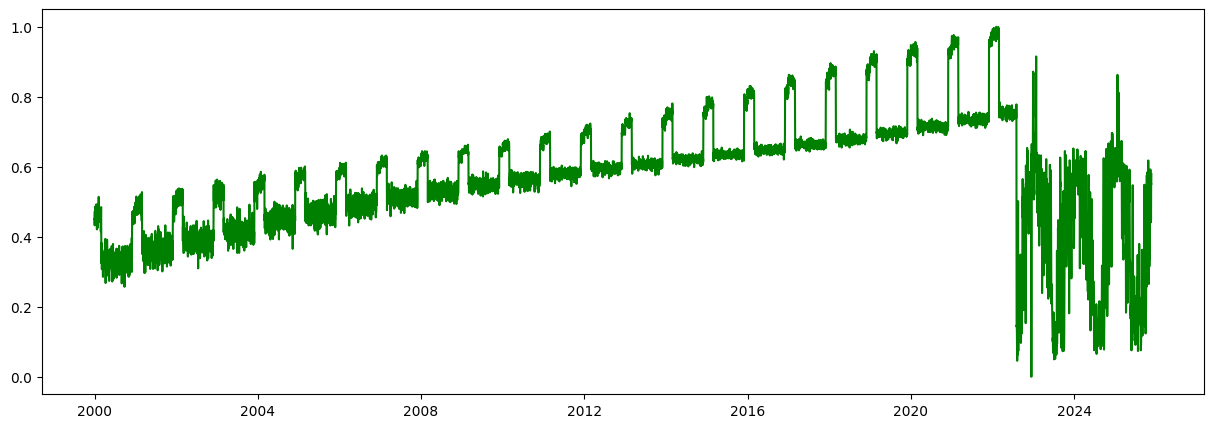

In [3]:
file_path = 'AQI Bangladesh.csv'
cols = ['city_name', 'datetime', 'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'aqi']

df = pd.read_csv(file_path, usecols=cols, parse_dates=['datetime'], index_col='datetime')
df_dhaka = df[df['city_name'] == 'Dhaka'].drop(columns=['city_name'])

df_daily = df_dhaka.resample('D').mean(numeric_only=True)
df_daily = df_daily.interpolate(method='time').dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df_daily), columns=df_daily.columns, index=df_daily.index)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, -1]) 
    return np.array(X), np.array(Y)

look_back = 30
data_values = df_scaled.values
X, y = create_dataset(data_values, look_back)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

plt.figure(figsize=(15, 5))
plt.plot(df_scaled.index, df_scaled['aqi'], color='green')
plt.show()

### **3. Implementasi Algoritma LSTM (NumPy)**

Bagian ini adalah **inti dari eksperimen teoritis**. Kita menerjemahkan rumus matematika LSTM (sesuai materi perkuliahan) menjadi kode Python murni tanpa bantuan *library* otomatis.

**Arsitektur Matematis:**
* **Gerbang (Gates):** Menggunakan fungsi aktivasi `Sigmoid` ($\sigma$) untuk gerbang *Input*, *Forget*, dan *Output*.
* **State Update:** Menggunakan `Tanh` untuk kandidat memori baru.
* **Forward Pass:** Menghitung aliran data dari $t=0$ sampai akhir *sequence*.
* **Backward Pass (BPTT):** Menghitung gradien error mundur ke belakang (*Backpropagation Through Time*) untuk memperbarui bobot $W$ dan bias $b$.

> **Catatan:** Variabel seperti `W_x` (bobot input) dan `W_s` (bobot hidden state) dikelola secara eksplisit untuk menunjukkan transparansi algoritma.

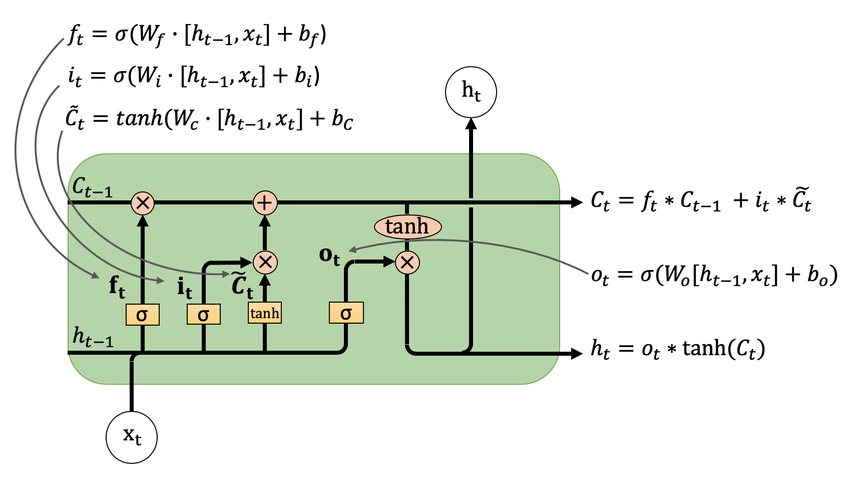

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def dsigmoid(y):
    return y * (1.0 - y)

def dtanh(y):
    return 1.0 - y * y

class LSTMNumpy:
    def __init__(self, input_size, hidden_size, output_size, seed=42):
        np.random.seed(seed)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        std = 1.0 / np.sqrt(hidden_size + input_size)
        self.W_x = np.random.randn(4 * hidden_size, input_size) * std
        self.W_s = np.random.randn(4 * hidden_size, hidden_size) * std
        self.b = np.zeros(4 * hidden_size)
        
        self.V = np.random.randn(output_size, hidden_size) * (1.0 / np.sqrt(hidden_size))
        self.c = np.zeros(output_size)
        
        self.reset_grads()

    def reset_grads(self):
        self.dW_x = np.zeros_like(self.W_x)
        self.dW_s = np.zeros_like(self.W_s)
        self.db = np.zeros_like(self.b)
        self.dV = np.zeros_like(self.V)
        self.dc = np.zeros_like(self.c)

    def init_hidden(self):
        return np.zeros((1, self.hidden_size)), np.zeros((1, self.hidden_size))

    def forward(self, xs):
        seq_len = xs.shape[0]
        H = self.hidden_size
        
        s_t = np.zeros(H)
        c_t = np.zeros(H)
        
        cache_list = []
        
        for t in range(seq_len):
            x_t = xs[t]
            
            z = self.W_x.dot(x_t) + self.W_s.dot(s_t) + self.b
            
            i_t = sigmoid(z[0*H:1*H])
            f_t = sigmoid(z[1*H:2*H])
            C_tilde_t = np.tanh(z[2*H:3*H])
            o_t = sigmoid(z[3*H:4*H])
            
            c_t = f_t * c_t + i_t * C_tilde_t
            s_t = o_t * np.tanh(c_t)
            
            cache_list.append((z, i_t, f_t, C_tilde_t, o_t, c_t, s_t))
            
        y = self.V.dot(s_t) + self.c
        return y, (xs, cache_list)

    def backward(self, dy, cache):
        xs, cache_list = cache
        seq_len = xs.shape[0]
        H = self.hidden_size
        
        self.reset_grads()
        
        ds_next = np.zeros(H)
        dc_next = np.zeros(H)
        
        s_last = cache_list[-1][6]
        
        self.dV += np.outer(dy, s_last)
        self.dc += dy
        
        ds_next = self.V.T.dot(dy)
        
        for t in reversed(range(seq_len)):
            z, i_t, f_t, C_tilde_t, o_t, c_t, s_t = cache_list[t]
            
            c_prev = cache_list[t-1][5] if t > 0 else np.zeros(H)
            s_prev = cache_list[t-1][6] if t > 0 else np.zeros(H)
            
            ds = ds_next
            dct = ds * o_t * dtanh(np.tanh(c_t)) + dc_next
            
            d_C_tilde = dct * i_t * dtanh(C_tilde_t)
            di = dct * C_tilde_t * dsigmoid(i_t)
            df = dct * c_prev * dsigmoid(f_t)
            do = ds * np.tanh(c_t) * dsigmoid(o_t)
            
            dz = np.hstack([di, df, d_C_tilde, do])
            
            self.dW_x += np.outer(dz, xs[t])
            self.dW_s += np.outer(dz, s_prev)
            self.db += dz
            
            ds_next = self.W_s.T.dot(dz)
            dc_next = dct * f_t
            
        for g in [self.dW_x, self.dW_s, self.db, self.dV, self.dc]:
            np.clip(g, -1, 1, out=g)

    def step(self, lr):
        self.W_x -= lr * self.dW_x
        self.W_s -= lr * self.dW_s
        self.b -= lr * self.db
        self.V -= lr * self.dV
        self.c -= lr * self.dc

    def predict(self, xs):
        y, _ = self.forward(xs)
        return y

### **4. Training & Evaluasi Model Manual (NumPy)**

Kita melatih model "rakitan tangan" ini selama 10 *epoch*. Proses ini membuktikan validitas algoritma yang kita tulis: jika *Loss* (Error) menurun, berarti mesin matematika kita berhasil "belajar" pola data.

**Analisis Visualisasi:**
* 🟣 **Grafik Ungu (Loss):** Menunjukkan penurunan drastis di awal epoch, menandakan konvergensi algoritma berjalan baik.
* 🔴 **Grafik Merah (Prediksi):** Garis putus-putus merah (prediksi model) terlihat mengikuti pola garis hijau (data asli) dengan cukup akurat, meskipun model ini dibangun secara manual.

Training Numpy LSTM...
Epoch 1/10 - Loss: 0.001335
Epoch 2/10 - Loss: 0.000307
Epoch 3/10 - Loss: 0.000299
Epoch 4/10 - Loss: 0.000293
Epoch 5/10 - Loss: 0.000288
Epoch 6/10 - Loss: 0.000284
Epoch 7/10 - Loss: 0.000280
Epoch 8/10 - Loss: 0.000277
Epoch 9/10 - Loss: 0.000274
Epoch 10/10 - Loss: 0.000270


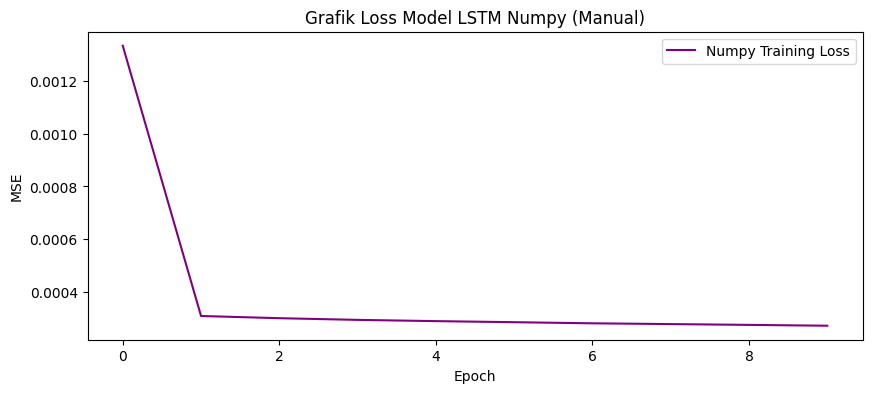

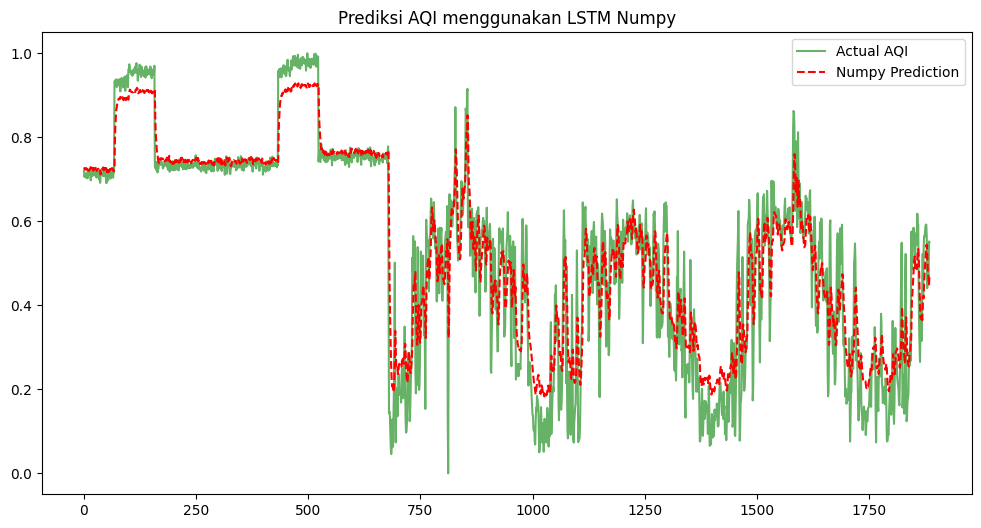

In [5]:
input_dim = X_train.shape[2]
hidden_dim = 32
output_dim = 1

model_numpy = LSTMNumpy(input_dim, hidden_dim, output_dim)

epochs = 10
lr = 0.01
loss_history_numpy = []

print("Training Numpy LSTM...")
for ep in range(epochs):
    epoch_loss = 0
    perm = np.random.permutation(len(X_train))
    
    for i in perm:
        xs = X_train[i]
        y_true = y_train[i]
        
        y_pred, cache = model_numpy.forward(xs)
        
        err = y_pred - y_true
        loss = 0.5 * (err ** 2)
        epoch_loss += loss
        
        model_numpy.backward(err, cache)
        model_numpy.step(lr)
        
    avg_loss = epoch_loss.item() / len(X_train)
    loss_history_numpy.append(avg_loss)
    print(f"Epoch {ep+1}/{epochs} - Loss: {avg_loss:.6f}")

plt.figure(figsize=(10, 4))
plt.plot(loss_history_numpy, label='Numpy Training Loss', color='purple')
plt.title('Grafik Loss Model LSTM Numpy (Manual)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

preds_numpy = []
for i in range(len(X_test)):
    p = model_numpy.predict(X_test[i])
    preds_numpy.append(p.item())

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual AQI', color='green', alpha=0.6)
plt.plot(preds_numpy, label='Numpy Prediction', color='red', linestyle='--')
plt.title('Prediksi AQI menggunakan LSTM Numpy')
plt.legend()
plt.show()

### **5. Implementasi Algoritma LSTM (TensorFlow/Keras)**

Sebagai pembanding, kita membangun model dengan arsitektur serupa menggunakan **TensorFlow**. Ini merepresentasikan standar industri.

**Konfigurasi Model:**
* **Layer LSTM:** 32 Unit neuron dengan aktivasi `tanh`.
* **Optimizer:** `Adam` (Adaptive Moment Estimation) dengan *learning rate* 0.01.
* **Early Stopping:** Mekanisme otomatis untuk menghentikan training jika validasi error tidak membaik, mencegah *overfitting*.

In [6]:
model_keras = Sequential()
model_keras.add(Input(shape=(look_back, X_train.shape[2])))
model_keras.add(LSTM(32, activation='tanh'))
model_keras.add(Dense(1))

model_keras.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_keras = model_keras.fit(X_train, y_train, 
                                epochs=20, 
                                batch_size=32, 
                                validation_data=(X_test, y_test), 
                                callbacks=[early_stop],
                                verbose=1)

Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.5552e-04 - val_loss: 0.0054
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.0084e-04 - val_loss: 0.0051
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8589e-04 - val_loss: 0.0049
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.6691e-04 - val_loss: 0.0054
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8962e-04 - val_loss: 0.0053
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9128e-04 - val_loss: 0.0064
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.7161e-04 - val_loss: 0.0065
Epoch 9/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.8343e-04 - val_loss: 0.0069


### **6. Evaluasi Model Library (Keras)**

Hasil training dari model TensorFlow dievaluasi menggunakan metrik yang sama (*Mean Squared Error*).

**Analisis Visualisasi:**
* 🔵 **Grafik Biru (Loss):** Menunjukkan kurva belajar yang stabil dan sangat rendah.
* 🔵 **Grafik Biru (Prediksi):** Prediksi pada data uji (*test set*) menunjukkan akurasi tinggi dalam menangkap tren naik-turun kualitas udara.

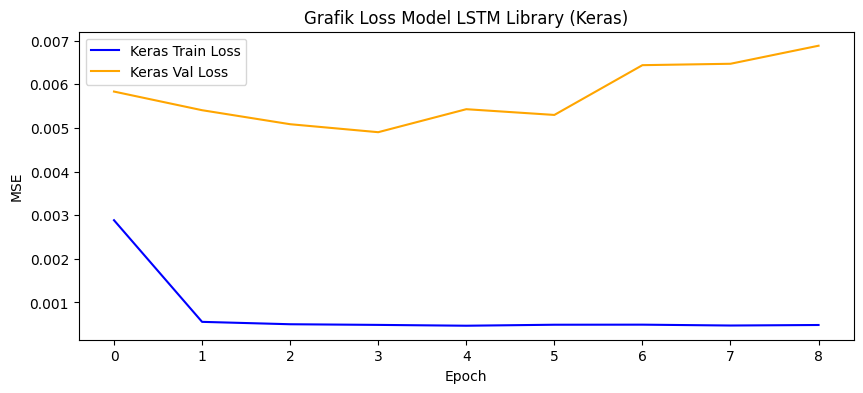

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


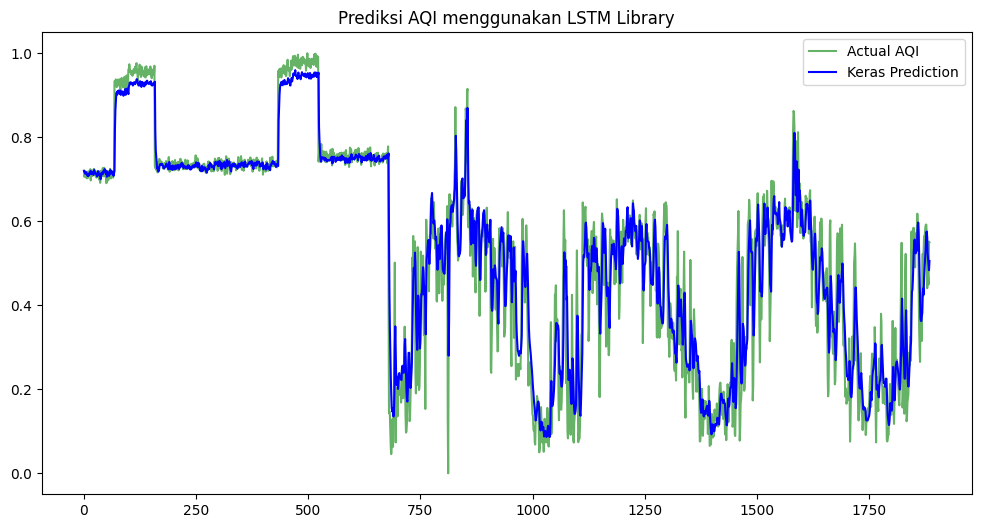

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(history_keras.history['loss'], label='Keras Train Loss', color='blue')
plt.plot(history_keras.history['val_loss'], label='Keras Val Loss', color='orange')
plt.title('Grafik Loss Model LSTM Library (Keras)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

preds_keras = model_keras.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual AQI', color='green', alpha=0.6)
plt.plot(preds_keras, label='Keras Prediction', color='blue')
plt.title('Prediksi AQI menggunakan LSTM Library')
plt.legend()
plt.show()

### **7. Komparasi Final: Manual vs Library**

Pada tahap akhir ini, kita mempertemukan kedua model secara *Head-to-Head*. Kita membandingkan nilai **MSE (Mean Squared Error)** dan memplot hasil prediksi keduanya dalam satu grafik.

**Interpretasi Hasil:**
* Grafik di bawah menampilkan **Data Asli (Hijau)**, **Prediksi NumPy (Merah)**, dan **Prediksi Keras (Biru)**.
* Jika garis Merah dan Biru berimpit atau memiliki pola yang sangat mirip, hal ini membuktikan bahwa **implementasi algoritma manual (NumPy) kita valid secara matematis** dan mampu menyamai logika komputasi *library* modern.

> **Kesimpulan:** Eksperimen ini berhasil memvalidasi pemahaman teoritis mengenai *Backpropagation Through Time* dan gerbang logika LSTM.

SUMMARY PERBANDINGAN MODEL
1. MSE Model Numpy (Manual)  : 0.006381
2. MSE Model Library (Keras) : 0.004903
----------------------------------------
Kesimpulan: Model Library memiliki error lebih kecil atau setara.


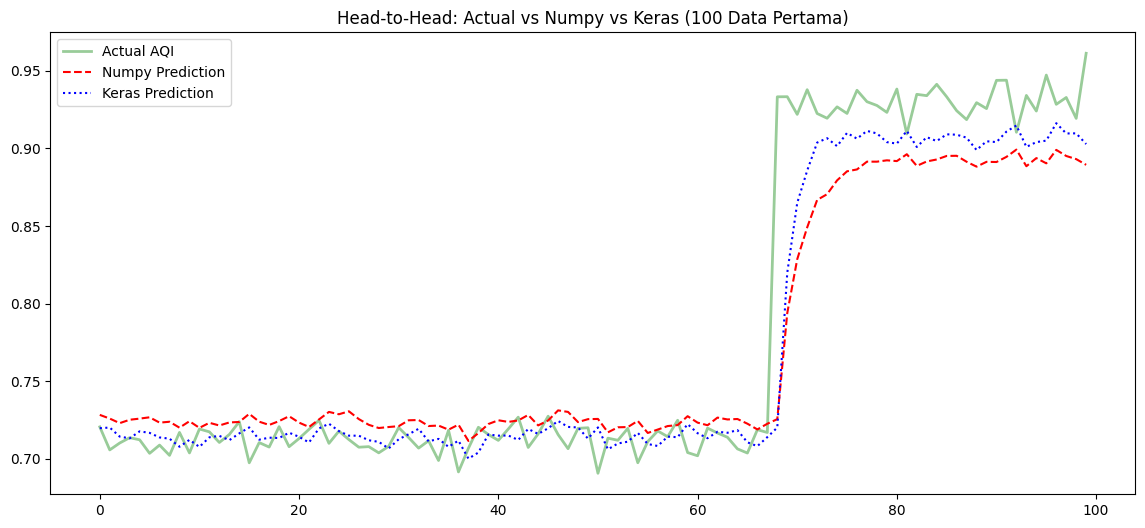

In [8]:
mse_numpy = np.mean((y_test - np.array(preds_numpy))**2)
mse_keras = model_keras.evaluate(X_test, y_test, verbose=0)

print("="*40)
print("SUMMARY PERBANDINGAN MODEL")
print("="*40)
print(f"1. MSE Model Numpy (Manual)  : {mse_numpy:.6f}")
print(f"2. MSE Model Library (Keras) : {mse_keras:.6f}")
print("-" * 40)

if mse_numpy < mse_keras:
    print("Kesimpulan: Model Numpy memiliki error lebih kecil pada data test.")
else:
    print("Kesimpulan: Model Library memiliki error lebih kecil atau setara.")

plt.figure(figsize=(14, 6))
plt.plot(y_test[:100], label='Actual AQI', color='green', linewidth=2, alpha=0.4)
plt.plot(preds_numpy[:100], label='Numpy Prediction', color='red', linestyle='--')
plt.plot(preds_keras[:100], label='Keras Prediction', color='blue', linestyle=':')
plt.title('Head-to-Head: Actual vs Numpy vs Keras (100 Data Pertama)')
plt.legend()
plt.show()